In [1]:
%matplotlib inline

from tqdm import tqdm
import os, sys, pathlib
from pprint import pprint
import gc, time
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")
from IPython.display import clear_output

import PyPDF2 as ppdf
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import pyaldata as pyal

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    defs = params.mouse_defs
    
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root
    reload(dt)
    reload(params)
    reload (defs)
finally:
    os.chdir(nbPath)

print('Done')

Done


In [2]:
def get_full_mouse_data():  
    animalList = ['mouse-data']
    animalFiles = []
    for animal in animalList:
        animalFiles.extend(utility.find_file(root / animal, 'mat'))

    AllDFs=[]
    for fname in animalFiles:
        df = dt.load_pyal_data(fname)
        df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
        df['file'] = fname.split(os.sep)[-1]
        df = defs.prep_general_mouse(df)
        AllDFs.append(df)

    allDFs_M1 = []
    for df in AllDFs:
        if 'M1_rates' in df.columns:
            allDFs_M1.append(df)


    allDFs_Str = []
    for df in AllDFs:
        if 'Str_rates' in df.columns:
            allDFs_Str.append(df)
            
    return allDFs_M1, allDFs_Str

In [3]:
Range = np.arange(-10,10)  # range of time lags to include

def mouse_vel_corrs(allDF:list[pd.DataFrame],epoch, shifted_epoch):
    pairFileList1 = []
    for I, df1 in enumerate(allDF):
        for J, (df2) in enumerate(allDF):
            if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
            pairFileList1.append((I,J))
    side1df = [allDF[i] for i,_ in pairFileList1]
    side2df = [allDF[j] for _,j in pairFileList1]

    across_good = across_bad = 0

    allcorrs=[]
    for i, j in pairFileList1:
        df1 = pyal.restrict_to_interval(allDF[i], epoch_fun=epoch)
        df2 = pyal.restrict_to_interval(allDF[j], epoch_fun=shifted_epoch)
        corrs = []

        targets = np.unique(df1.target_id)
        for target in targets:
            df1_ = pyal.select_trials(df1, df1.target_id == target)
            df2_ = pyal.select_trials(df2, df2.target_id == target)

            for i, vel1 in enumerate(df1_.hTrjB):
                for j, vel2 in enumerate(df2_.hTrjB):
                    try:
                        r = [pearsonr(*del_nan(aa,bb))[0] for aa,bb in zip(vel1.T,vel2.T)]
                        corrs.append(np.mean(np.abs(r)))
                        across_good += 1
                    except: continue
        allcorrs.append(np.mean(corrs))

    return allcorrs, pairFileList1

def calc_time_lag_behavior(allDFs, bin_size = defs.BIN_SIZE):
    allcorrs = []
    for i in Range:
        # print(i)
        exec_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on',
                                        rel_start=int(defs.WINDOW_exec[0]/bin_size),
                                        rel_end=int(defs.WINDOW_exec[1]/bin_size)
                                        )
        shifted_exec_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on',
                                        rel_start=int(defs.WINDOW_exec[0]/bin_size)+i,
                                        rel_end=int(defs.WINDOW_exec[1]/bin_size)+i
                                        )
        corrs, pairFileList = mouse_vel_corrs(allDFs, exec_epoch, shifted_exec_epoch)
        allcorrs.append(corrs)
    allcorrs = np.array(allcorrs)
    return allcorrs, pairFileList

def del_nan(a,b):
    a_bad = np.isnan(a)
    b_bad = np.isnan(b)
    bad = np.logical_or(a_bad,b_bad)
    good = np.logical_not(bad)
    
    return a[good], b[good]

In [41]:
allDFs_M1, allDFs_Str = get_full_mouse_data()
allcorrs_10ms , pairFileList = calc_time_lag_behavior(allDFs_M1, bin_size=0.01)
allcorrs_30ms , pairFileList = calc_time_lag_behavior(allDFs_M1, bin_size=0.03)
allcorrs_50ms , pairFileList = calc_time_lag_behavior(allDFs_M1, bin_size=0.05)

In [42]:
#best time lags
print('10ms:', [Range[x] for x in np.argmax(allcorrs_10ms,0)])
print('30ms:',[Range[x] for x in np.argmax(allcorrs_30ms,0)])
print('50ms:',[Range[x] for x in np.argmax(allcorrs_50ms,0)])


10ms: [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
30ms: [1, 0, 0, 0, 7, -1, 0, 9, -1, 0, 0, 0, 0]
50ms: [1, 0, 0, 1, 7, -1, 0, 9, -1, 0, 0, 0, 0]


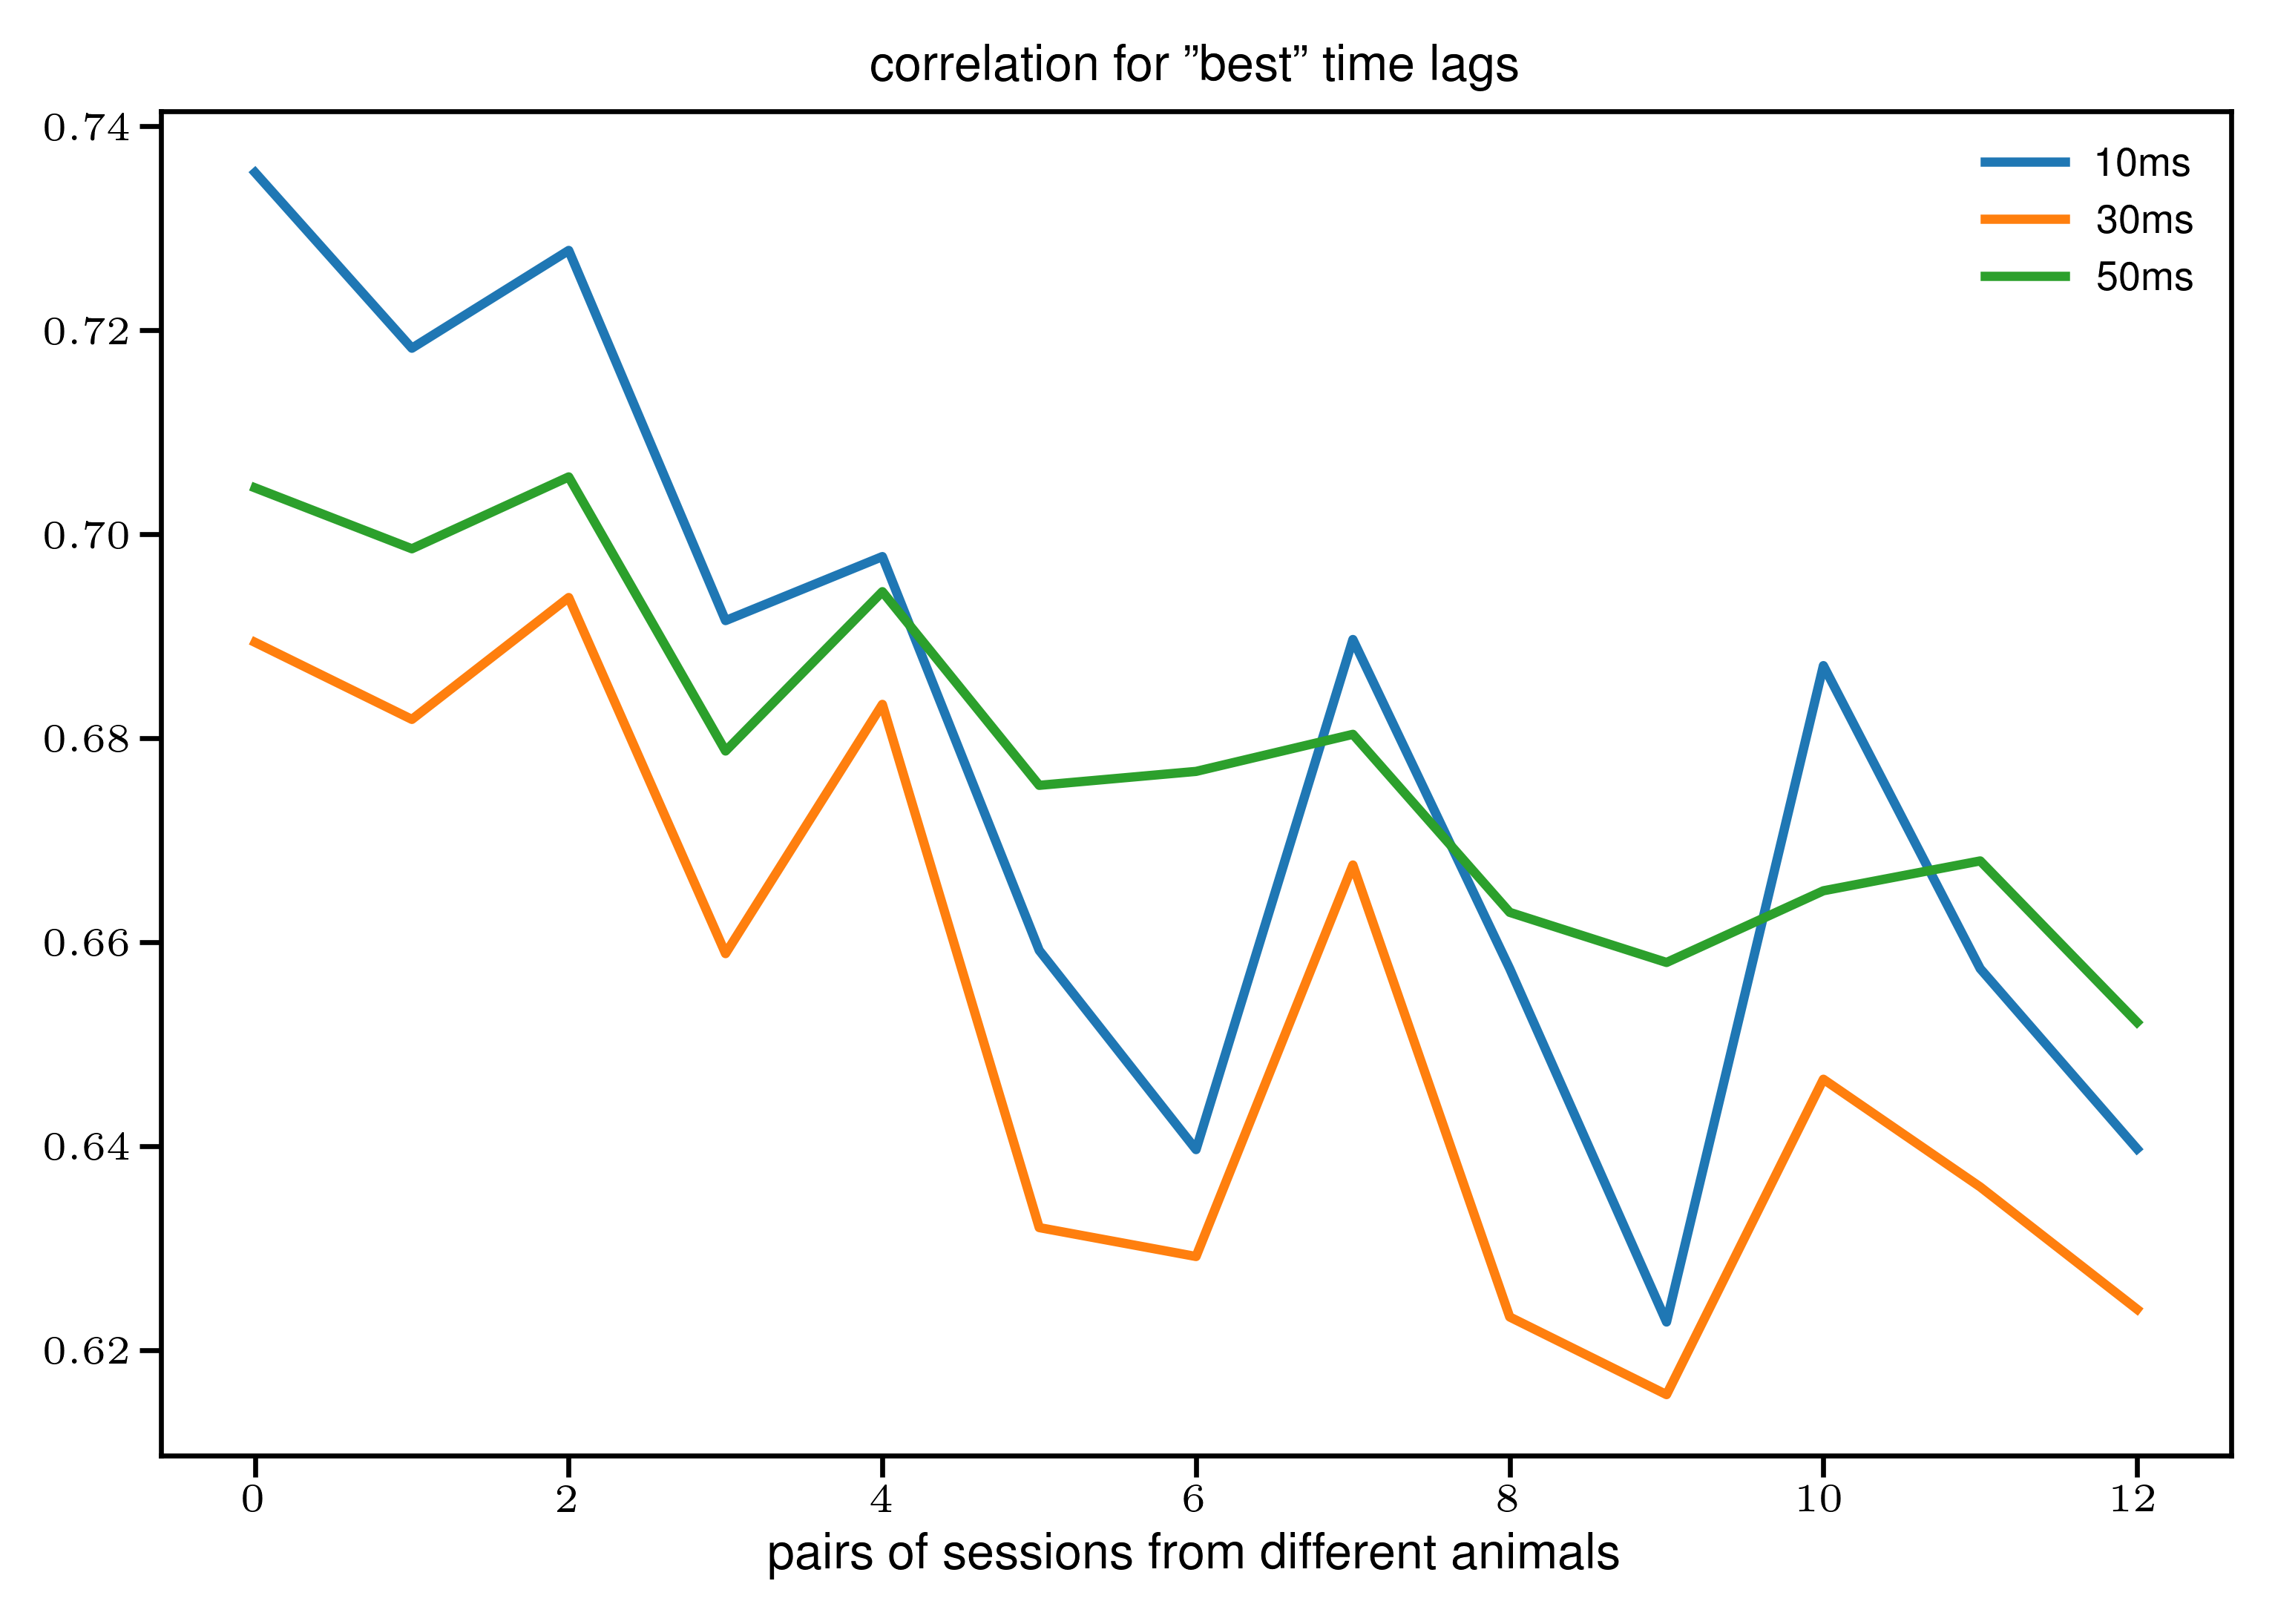

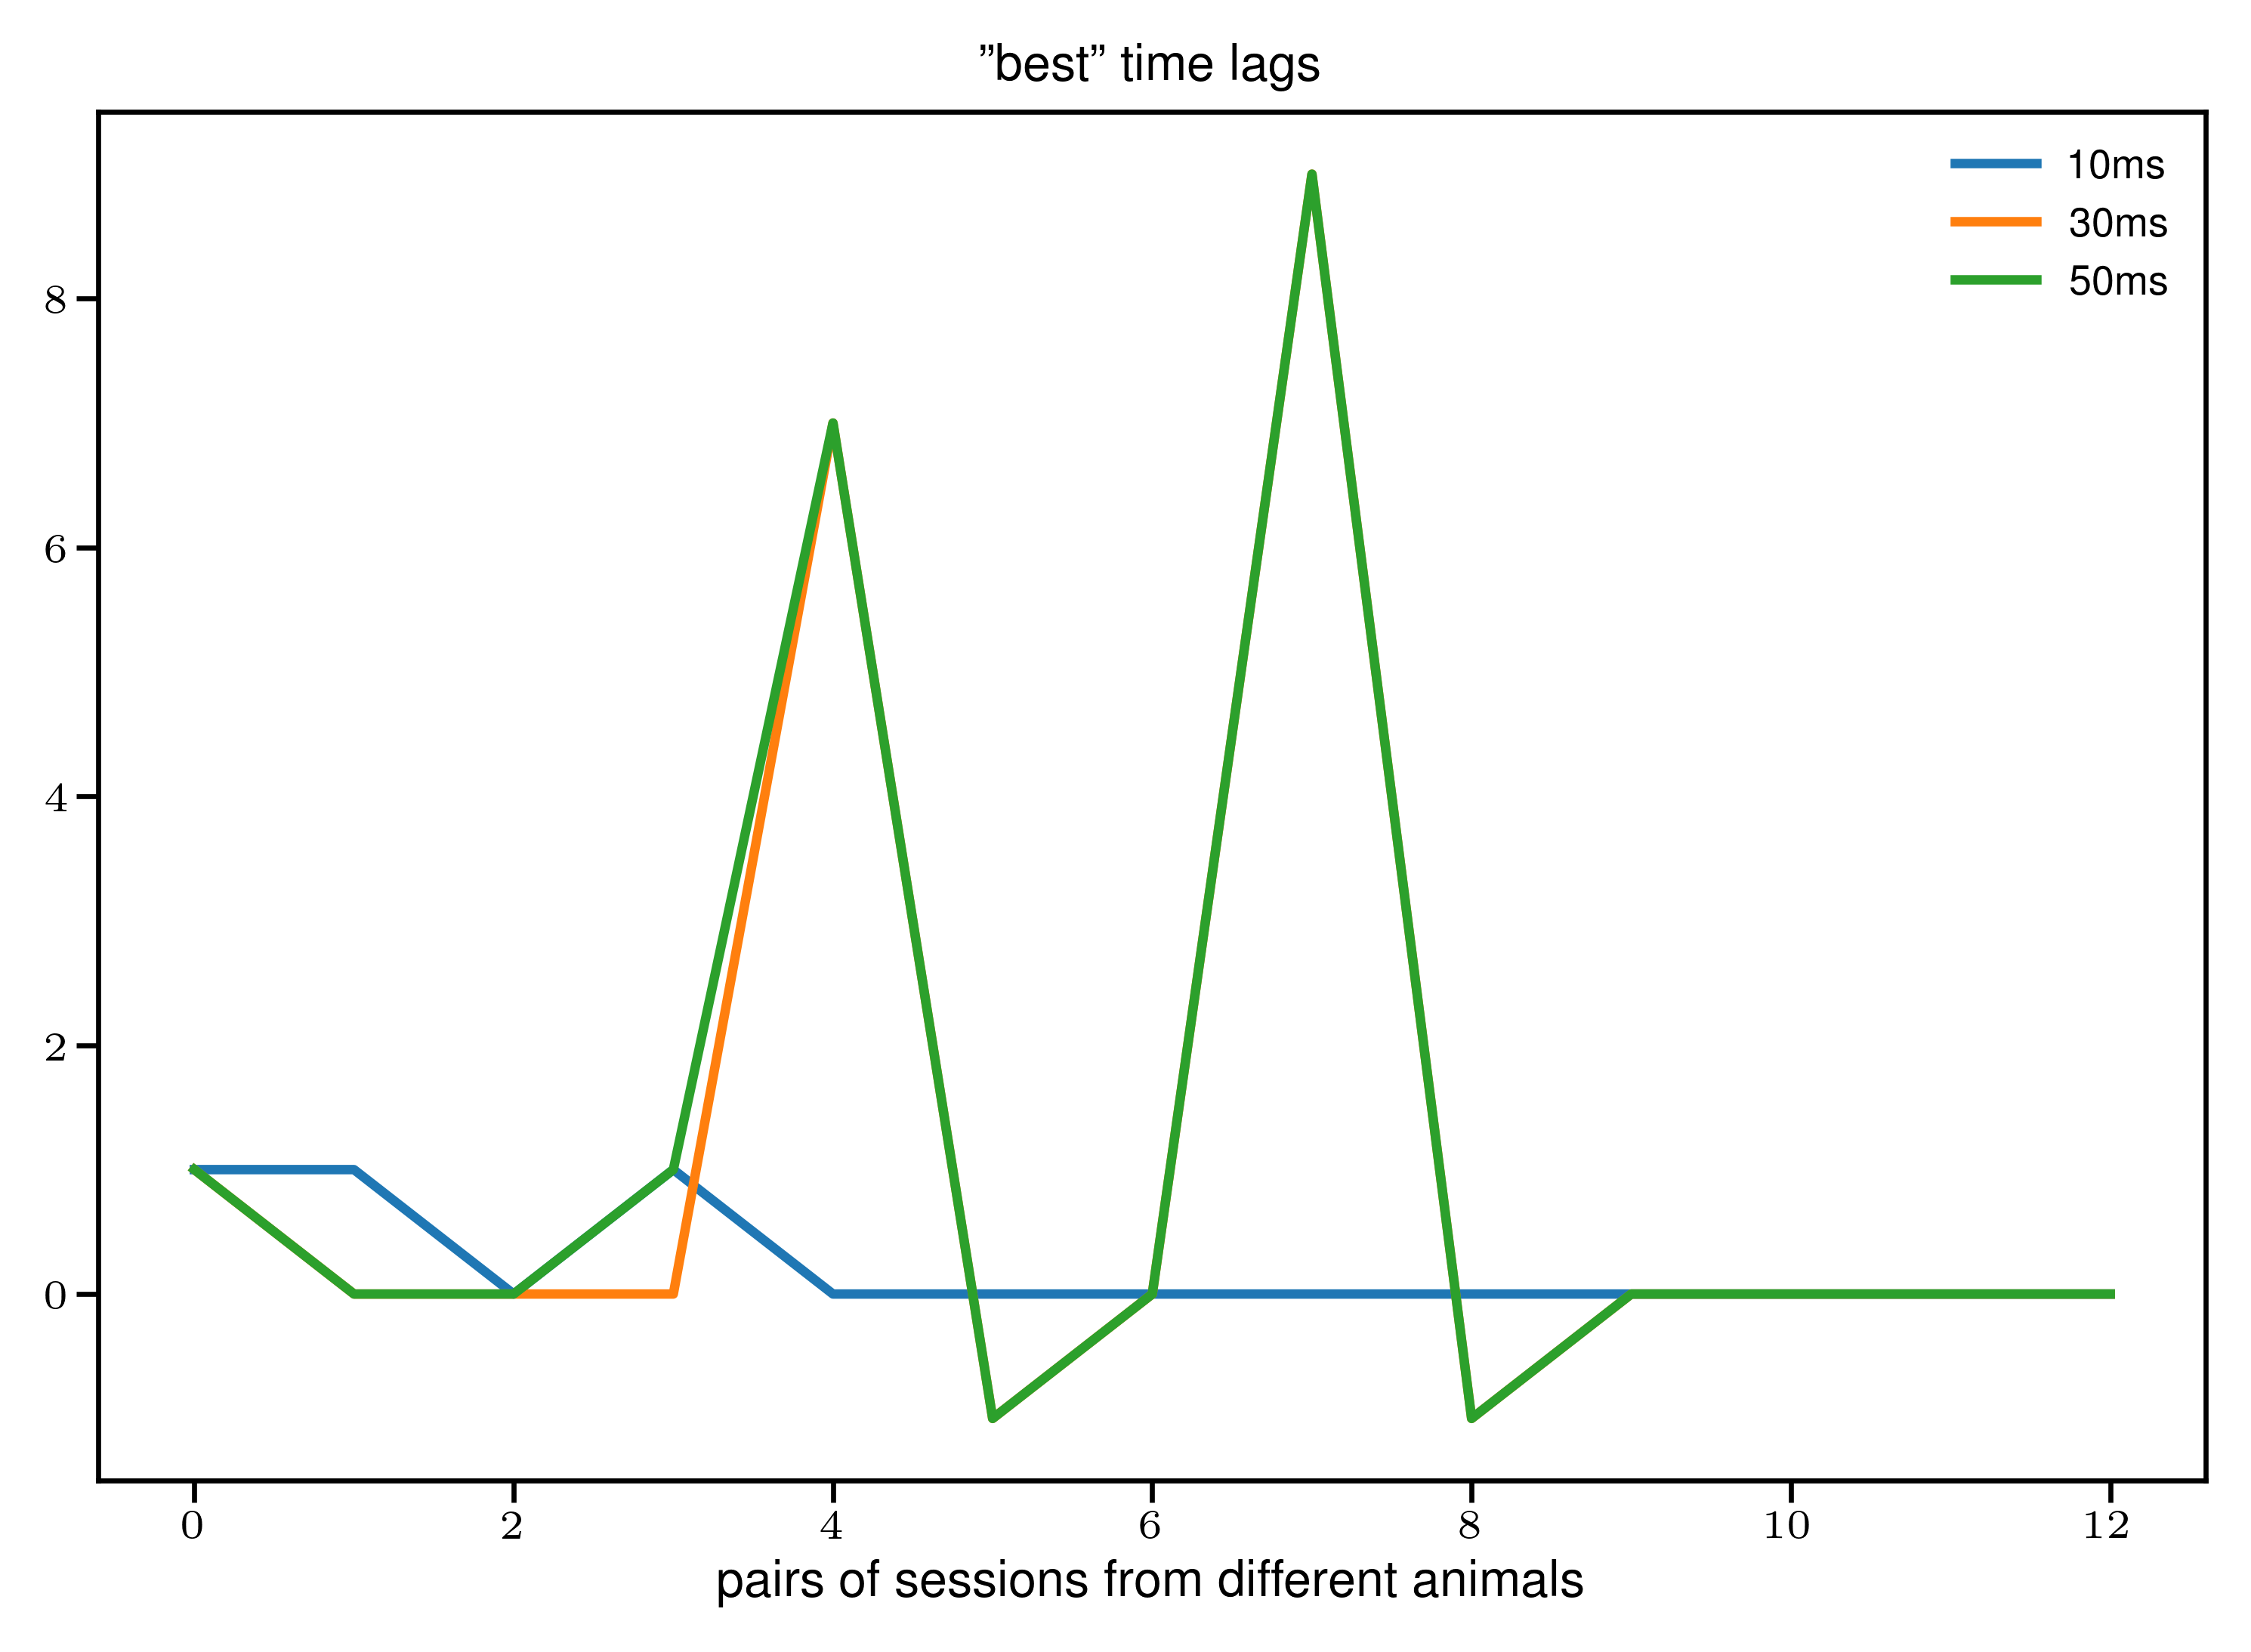

In [49]:
cmap = [mpl.cm.get_cmap('plasma_r')(i) for i in np.linspace(0.1,0.9,len(Range))]

plt.figure()
plt.plot(np.max(allcorrs_10ms, 0), label = '10ms')
plt.plot(np.max(allcorrs_30ms, 0), label = '30ms')
plt.plot(np.max(allcorrs_50ms, 0), label = '50ms')

plt.xlabel('pairs of sessions from different animals')
plt.legend()
plt.title('correlation for "best" time lags')
plt.savefig('behav_corr_best_timelags')

plt.figure()
plt.plot([Range[x] for x in np.argmax(allcorrs_10ms,0)], label = '10ms')
plt.plot([Range[x] for x in np.argmax(allcorrs_30ms,0)], label = '30ms')
plt.plot([Range[x] for x in np.argmax(allcorrs_50ms,0)], label = '50ms')

plt.xlabel('pairs of sessions from different animals')
plt.legend()
plt.title('"best" time lags')
plt.savefig('behav_timelags')

In [4]:
def save_mouse_lag_pickles(allDFs, bin_size = defs.BIN_SIZE):
    all_corrs, pairFileList = calc_time_lag_behavior(allDFs, bin_size)

    pathPickle = root / 'mouse-data'
    for ind, (i,j) in enumerate(pairFileList):
        bin_shift = Range[np.argmax(all_corrs, axis=0)[ind]]

        df1 = allDFs[i]
        df2 = allDFs[j]
        pickleFile1 = pathPickle / f'behav_lag_{bin_size}-{df1.file[0]}-{df2.file[0]}.p'
        pickleFile2 = pathPickle / f'behav_lag_{bin_size}-{df2.file[0]}-{df1.file[0]}.p'
        
        print(f'{pickleFile1}: {bin_shift}')

        with open(pickleFile1, 'wb') as f:
            pickle.dump(bin_shift, f)
            f.close()
        with open(pickleFile2, 'wb') as f:
                pickle.dump(-bin_shift, f)
                f.close()


In [5]:
allDFs_M1, allDFs_Str = get_full_mouse_data()
save_mouse_lag_pickles(allDFs_M1)

/home/jcc319/multi_animal_alignment/packages/pyaldata/pyaldata/firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/jcc319/multi_animal_alignment/packages/pyaldata/pyaldata/firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/jcc319/multi_animal_alignment/packages/pyaldata/pyaldata/firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/jcc319/multi_animal_alignment/packages/pyaldata/pyaldata/firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/jcc319/multi_a

/home/jcc319/multi_animal_alignment/data/mouse-data/behav_lag_0.03-js2p0_tbytSpkHandJsTrj10msBin_WR40_082019_ss.mat-js2p0_tbytSpkHandJsTrj10msBin_WR38_052219_ss.mat.p: 1
/home/jcc319/multi_animal_alignment/data/mouse-data/behav_lag_0.03-js2p0_tbytSpkHandJsTrj10msBin_WR40_082019_ss.mat-js2p0_tbytSpkHandJsTrj10msBin_WR38_052419_ss.mat.p: 0
/home/jcc319/multi_animal_alignment/data/mouse-data/behav_lag_0.03-js2p0_tbytSpkHandJsTrj10msBin_WR40_082019_ss.mat-js2p0_tbytSpkHandJsTrj10msBin_WR39_100219_ss.mat.p: 0
/home/jcc319/multi_animal_alignment/data/mouse-data/behav_lag_0.03-js2p0_tbytSpkHandJsTrj10msBin_WR40_082019_ss.mat-js2p0_tbytSpkHandJsTrj10msBin_WR44_031020_ss.mat.p: 0
/home/jcc319/multi_animal_alignment/data/mouse-data/behav_lag_0.03-js2p0_tbytSpkHandJsTrj10msBin_WR38_052219_ss.mat-js2p0_tbytSpkHandJsTrj10msBin_WR40_081919_ss.mat.p: 7
/home/jcc319/multi_animal_alignment/data/mouse-data/behav_lag_0.03-js2p0_tbytSpkHandJsTrj10msBin_WR38_052219_ss.mat-js2p0_tbytSpkHandJsTrj10msBin_WR39